# Pre-Modelling

**Mounting Colab notebook to Drive**

In [1]:
# Mounting colab notebook to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Installing relevant packages + importing common modules* **(AI-FEYNMAN)**

In [2]:
# Checking OS version, fortran compiler version, and granting relevant permissions (github only)
!sudo apt-get install csh
!lsb_release -a
!gfortran --version
!chmod +777 '/content/drive/My Drive/Symbolic-Regressor/Feynman Local/'*

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  csh
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 245 kB of archives.
After this operation, 358 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 csh amd64 20110502-7 [245 kB]
Fetched 245 kB in 1s (230 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package csh.
(Reading database ... 123594 files and directories currently installed.

In [3]:
# Installing AI Feynman 2.0, c shell, and relevant packages
## https://ai-feynman.readthedocs.io/en/latest/
!pip install aifeynman --no-deps
!pip install sortedcontainers scikit-learn torch seaborn torchvision openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for aifeynman: filename=aifeynman-2.0.7-cp310-cp310-linux_x86_64.whl size=915216 sha256=d6e1b440d5e0936c6cc4bca025f9b89d372a6c1ec4ca71509b58cdc672def80a
  Stored in directory: /root/.cache/pip/wheels/5d/f2/9b/73448a5c9458d5b02e08fc010b0e21ab88ed5cbd0e0aa91a99
Successfully built aifeynman
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using

In [4]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time

import aifeynman

#Configuring matplotlib
%matplotlib inline

*Installing relevant packages + importing common modules* **(PYSR)**

In [5]:
# Julia installation
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.0" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

In [6]:
!pip install pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 1.9 MB/s eta 0:00:00


In [22]:
# !pip install pysr

import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time

from pysr import pysr, best, PySRRegressor

#Configuring matplotlib
%matplotlib inline

# Lotka-Volterra Modelling

*Initialising data collection*

In [8]:
# model parameters
a = 0.7; b = 0.5     ## prey parameters
c = 0.3;  e = 0.2     ## predator parameters
dt = 0.001; max_time = 100     ## time parameters

# initial time and populations
t = 0; x = 1.0; y = 0.5     ## generally y < x

# empty lists in which to store time and populations
t_list = []; x_list = []; y_list = []

# initialize lists
t_list.append(t)
x_list.append(x)
y_list.append(y)

*Data collection*

In [9]:
# while loop for data collection
while t < max_time:
    # calc new values for t, x, y
    t = t + dt
    x = x + (a*x - b*x*y)*dt
    y = y + (-c*y + e*x*y)*dt

    # store new values in lists
    t_list.append(t)
    x_list.append(x)
    y_list.append(y)

*Plotting data*

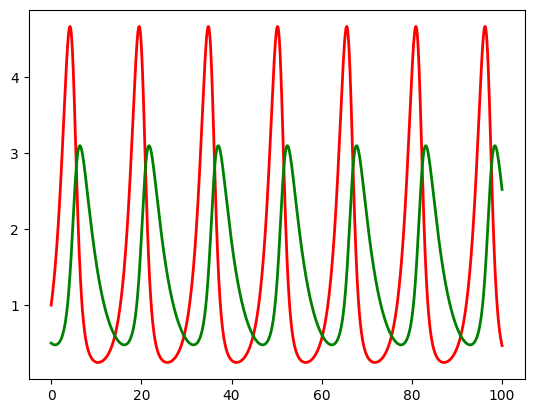

In [10]:
# Plot the results
p = plt.plot(t_list, x_list, 'r', t_list, y_list, 'g', linewidth = 2)

# Data Processing (AI-Feynman)

*Verifying working directory*

In [11]:
input_path = '/content/drive/My Drive/Symbolic-Regressor/Feynman Local/Lotka-Volterra/'
os.chdir(input_path)
!pwd
data_file = 'lv_xdata.txt'

/content/drive/My Drive/Symbolic-Regressor/Feynman Local/Lotka-Volterra


*Parsing x-data and converting into readable .txt file*

In [12]:
# Process - intermediary text file created, x(t-1) and y(t-1) values for first row invalid,
# therefore first line of data deleted, final text file used as 10000-row data file.

with open('lv_xdata.txt', 'w') as lv:
  for r in range(10001):
    if r == 0:
      pass
    else:
      lv.write(f'{a} {b} {dt} {x_list[r-1]} {y_list[r-1]} {x_list[r]}\n')

data_file = 'lv_xdata.txt'

*Parsing y-data and converting into readable .txt file*

In [13]:
# Process - intermediary text file created, x(t-1) and y(t-1) values for first row invalid,
# therefore first line of data deleted, final text file used as 10000-row data file.

with open('lv_ydata.txt', 'w') as lv:
  for r in range(10001):
    if r == 0:
      pass
    else:
      lv.write(f'{c} {e} {dt} {x_list[r-1]} {y_list[r-1]} {y_list[r]}\n')

data_file = 'lv_ydata.txt'

*Creating custom set of operators*

In [14]:
# Custom operator set to be stored in local text file. Refer to list of operators provided below:
## https://github.com/SJ001/AI-Feynman/blob/master/aifeynman/tools.f90

with open('cops.txt', 'w') as cops:
  cops.write('+-*D~0')

*Running brute force test on generated data*

In [ ]:
#Running brute force test on perfect data (NOTE: Not counted in timing of symbolic regression function)
!pwd
aifeynman.S_brute_force.brute_force(input_path,data_file,30,"7ops.txt")

/content/drive/My Drive/Symbolic-Regressor/Feynman Local/Lotka-Volterra
Trying to solve mysteries with brute force...
Trying to solve /content/drive/My Drive/Symbolic-Regressor/Feynman Local/Lotka-Volterra/lv_ydata.txt
Rejection threshold.....    10.000
Bit margin..............     0.000
Number of variables.....       5
Functions used..........               +*/>~R0
 Arity            0 : 0abcde
 Arity            1 : >~R
 Arity            2 : +*/
Loading mystery data....
       10000  rows read from file mystery.dat                                                                                                                                                                                                                                                     
Number of examples......   10000
Removing problematically
   3.0951857849139106        3.0951859319273468E-003
           0  out of        10000  data points discarded for being too close to zero
Shuffling mystery data..
 Searching fo

*Running symbolic regression on generated data*

In [ ]:
# Running symbolic regression function on generated dataset
!pwd
start_time = time.time()
aifeynman.S_run_aifeynman.run_aifeynman(input_path,data_file,30,"7ops.txt", polyfit_deg=3, NN_epochs=600)
print(time.time() - start_time)

/content/drive/MyDrive/Symbolic-Regressor/Feynman Local/Lotka-Volterra
Checking for brute force + 

Trying to solve mysteries with brute force...
Trying to solve /content/drive/My Drive/Symbolic-Regressor/Feynman Local/Lotka-Volterra/lv_ydata.txt_train
Checking for brute force * 

Trying to solve mysteries with brute force...
Trying to solve /content/drive/My Drive/Symbolic-Regressor/Feynman Local/Lotka-Volterra/lv_ydata.txt_train
Checking polyfit 

Pareto frontier in the current branch:

Complexity #  MDL Loss #  Expression
33.45 17.99 0.000029422726+x4
44.5 17.99 -0.000970577274+(x4+x2)
55.35 16.67 -0.000555822136+(x4+(x3*(x2*x0)))
63.02 7.15 0.999700008668*(x4*((x3*(x2*x1))+1))

Checking for brute force + 

Trying to solve mysteries with brute force...
Trying to solve results/mystery_world_squared/lv_ydata.txt_train
Checking for brute force * 

Trying to solve mysteries with brute force...
Trying to solve results/mystery_world_squared/lv_ydata.txt_train
Checking polyfit 

Pareto fro

*Viewing processed results*

In [ ]:
# Viewing processed data
!ls -1 '/content/drive/My Drive/Symbolic-Regressor/Feynman Local/Lotka-Volterra/results'

os.chdir('/content/drive/My Drive/Symbolic-Regressor/Feynman Local/Lotka-Volterra/results/')

with open('solution_' + data_file, 'r') as f:
  print(f.read())

gen_sym
gradients_gen_sym_lv_ydata.txt_train
gradients_gen_sym_lv_ydata.txt_train-gen_sym
gradients_gen_sym_lv_ydata.txt_train-gen_sym-gen_sym
mystery_world_acos
mystery_world_asin
mystery_world_atan
mystery_world_cos
mystery_world_exp
mystery_world_inverse
mystery_world_log
mystery_world_sin
mystery_world_sqrt
mystery_world_squared
mystery_world_tan
NN_trained_models
solution_before_snap_lv_ydata.txt.txt
solution_first_snap_lv_ydata.txt.txt
solution_lv_ydata.txt
translated_data_divide
22.274728672939293 4.927184676189471 49271.84676189471 23.509775004326936 30.424985624960893 exp(-31.627027330236+sqrt((sqrt(sqrt(sqrt(sqrt(x4))))/x2)))
30.431739510642977 4.885484857697567 48854.84857697567 24.991183425621394 29.558166116101443 1/(-666.000000000000+(((x2/x4)+1)/x2))
18.015392529720575 4.169503137704312 41695.03137704312 33.45428377170377 17.994737323586374 0.000029422726+x4
18.015392529710123 4.169503137703459 41695.03137703459 33.45428377170568 17.99473732357574 -0.999970577274+((((x2+

# Data Processing (PySR)

*Verifying working directory*

In [15]:
input_path = '/content/drive/My Drive/Symbolic-Regressor/Feynman Local/Lotka-Volterra/'
os.chdir(input_path)
!pwd

/content/drive/My Drive/Symbolic-Regressor/Feynman Local/Lotka-Volterra


*Obtaining x-data from text file and converting into numpy arrays compatible with PySR*

In [16]:
#Converting raw x-data in .txt file to lists compatible with PySR
os.chdir(input_path)
xdata_values = []
xfinal_values = []
with open(data_file, 'r+') as f:
    for row in f:
        xdata_values.append([float(x) for x in row.split()])

for arr in xdata_values:
    xfinal_values.append(arr[-1])
    del arr[-1]

lv_xdata_pysr = np.array(xdata_values)
lv_xfinal_pysr = np.array(xfinal_values)

*Running symbolic regression on generated x-data*

In [19]:
# Running PySR symbolic regression on data with time measurements. Default settings (operators, iterations etc used)
# https://github.com/MilesCranmer/PySR/blob/master/docs/operators.md
os.chdir(input_path)
start_time = time.time()
equations = pysr(
    lv_xdata_simple_pysr, #doesn't work for this script, can skip cell
    lv_xfinal_simple_pysr,
    niterations=5,
)

...# (you can use ctl-c to exit early)

print(best(equations))
print(time.time() - start_time)

*Parsing x-data and converting into nested lists (suitable for PySR)*

In [26]:
# Generating x(t-1), y(t-1) + a,b,dt list, forming readable numpy array
xminus_list = []
yminus_list = []
a_list = []
b_list = []
dt_list = []

for r in range(10001):
  xminus_list.append(x_list[r-1])
  yminus_list.append(y_list[r-1])

xminus_list = xminus_list[1:]
yminus_list = yminus_list[1:]

for r in range(10000):
  a_list.append(a)
  b_list.append(b)
  dt_list.append(dt)

xdata_list = np.stack([a_list, b_list, dt_list, xminus_list, yminus_list]).transpose()  ## A bit inefficient, but it gets the job done
xfinal_list = x_list[1:]
print(xfinal_list)

[1.00045, 1.00090022748874, 1.0013506825660536, 1.0018013653317988, 1.002252275885857, 1.0027034143281333, 1.0031547807585566, 1.0036063752770796, 1.0040581979836787, 1.0045102489783535, 1.0049625283611276, 1.0054150362320482, 1.0058677726911855, 1.0063207378386338, 1.0067739317745108, 1.0072273545989572, 1.0076810064121373, 1.008134887314239, 1.0085889974054736, 1.0090433367860752, 1.0094979055563016, 1.009952703816434, 1.0104077316667763, 1.0108629892076562, 1.011318476539424, 1.0117741937624538, 1.0122301409771421, 1.012686318283909, 1.0131427257831973, 1.013599363575473, 1.014056231761225, 1.0145133304409653, 1.0149706597152286, 1.0154282196845725, 1.0158860104495777, 1.0163440321108475, 1.0168022847690081, 1.0172607685247084, 1.01771948347862, 1.0181784297314376, 1.0186376073838777, 1.0190970165366802, 1.0195566572906074, 1.020016529746444, 1.0204766340049976, 1.0209369701670978, 1.0213975383335971, 1.0218583386053703, 1.0223193710833147, 1.0227806358683496, 1.023242133061417, 1.0

*Running symbolic regression on generated x-data*

In [ ]:
# Running PySR symbolic regression on data with time measurements. Default settings (operators, iterations etc used)
# https://github.com/MilesCranmer/PySR/blob/master/docs/operators.md
os.chdir(input_path)
# start_time = time.time()
# equations = pysr(
#     lv_xdata_pysr,
#     lv_xfinal_pysr,
#     niterations=5,
# )

# ...# (you can use ctl-c to exit early)

# print(best(equations))
# print(time.time() - start_time)

In [28]:
model = PySRRegressor(
        niterations=5,  # < Increase me for better results
        binary_operators=["+", "*", "-", "/"],
        unary_operators=[
            "sign",
            "neg",
            "cos",
            "exp",
            "sin",  # Pre-defined library of operators (see docs)
            "inv(x) = 1/x",  # Define your own operator! (Julia syntax)
        ],
        extra_sympy_mappings={"inv": lambda x: 1 / x},
        # ^ Define operator for SymPy as well
        elementwise_loss="loss(prediction, target) = (prediction - target)^2",
        # ^ Custom loss function (julia syntax)
    )

print(model.fit(lv_xdata_pysr, lv_xfinal_pysr))

[ Info: Started!



Expressions evaluated per second: 4.540e+02
Head worker occupation: 0.0%
Progress: 1 / 75 total iterations (1.333%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
4           1.376e+00  3.986e+00  y = sign(sign(sin(0.014168)))
5           3.599e-01  1.341e+00  y = x₀ + (x₄ + x₀)
6           2.920e-01  2.089e-01  y = neg(cos(sign(x₄))) + x₄
7           2.940e-02  2.296e+00  y = (0.5782 * -0.81521) + (x₄ + x₀)
10          1.633e-03  9.635e-01  y = neg(cos(sign(-1.7526))) + ((x₀ + x₄) + x₁)
12          7.912e-04  3.623e-01  y = (x₄ + x₀) + ((x₀ + neg(cos(sign(x₄)))) / 0.88421)
13          2.405e-04  1.191e+00  y = (((x₀ + x₄) + x₁) + neg(sin(cos(sign(-1.7526))))) - x₂
14          2.639e-07  6.815e+00  y = (neg(cos(sign(x₄ / x₃) - 0.072574)) + x₀) + (x₄ + x₀)
---------------------------------------------------------------------------------------------------
Press 'q' and then <ente

In [29]:
print(model.sympy()) #get best fit expression

x4 - (-x0 + cos(x1*x3 + x1*x3 + 0.5199182))*sin(x2)


*Parsing y-data and converting into nested lists (suitable for PySR)*

In [30]:
# Generating x(t-1), y(t-1) + a,b,dt list, forming readable numpy array
xminus_list = []
yminus_list = []
c_list = []
e_list = []
dt_list = []

for r in range(10001):
  xminus_list.append(x_list[r-1])
  yminus_list.append(y_list[r-1])

xminus_list = [1:]
yminus_list = [1:]

for r in range(10000):
  c_list.append[c]
  e_list.append[e]
  dt_list.append[dt]

ydata_list = np.stack([c_list, e_list, dt_list, xminus_list, yminus_list]).transpose()  ## A bit inefficient, but it gets the job done
yfinal_list = y_list[1:]

SyntaxError: invalid syntax (<ipython-input-30-b0c792caa1b1>, line 12)

*Running symbolic regression on generated y-data*

In [ ]:
# Running PySR symbolic regression on data with time measurements. Default settings (operators, iterations etc used)
# https://github.com/MilesCranmer/PySR/blob/master/docs/operators.md
os.chdir(input_path)
start_time = time.time()
equations = pysr(
    ydata_list,
    yfinal_list,
    niterations=5,
)

...# (you can use ctl-c to exit early)

print(best(equations))
print(time.time() - start_time)